In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import random

import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns
# %matplotlib inline

from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn import metrics
from sklearn import feature_selection

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn import random_projection

#plotly imports
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import plot, iplot

<h1><center>Data overview</center></h1>

| Variable | Description |
|:---|:---|
id | Unique ID for each home sold
date | Date of the home sale
price | Price of each home sold
bedrooms | Number of bedrooms
bathrooms | Number of bathrooms, where .5 accounts for a room with a toilet but no shower
sqft_living | Square footage of the apartments interior living space
sqft_lot | Square footage of the land space
floors | Number of floors
waterfront | A dummy variable for whether the apartment was overlooking the waterfront or not
view | An index from 0 to 4 of how good the view of the property was
condition | An index from 1 to 5 on the condition of the apartment 
grade | An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design 
sqft_above | The square footage of the interior housing space that is above ground level
sqft_basement | The square footage of the interior housing space that is below ground slevel
yr_built | The year the house was initially built
yr_renovated | The year of the house’s last renovation
zipcode | What zipcode area the house is in
lat | Lattitude
long | Longitude
sqft_living15 | The square footage of interior housing living space for the nearest 15 neighbors
sqft_lot15 | The square footage of the land lots of the nearest 15 neighbors


<h2><center>Scores</center></h2>

<h3><center>Silhouette</center></h3>
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

\begin{equation*}
a(i) = \frac{1}{|C_i| - 1} \sum_{j \in C_i, i \neq j} d(i, j)
\end{equation*}


<h3><center>Rand index adjusted for chance</center></h3>
The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

\begin{equation*}
ARI = \frac{(RI - Expected\_RI)}{(max(RI) - Expected\_RI)}
\end{equation*}

<h2><center>Data Analysis</center></h2>

data.describe



In [2]:
housesO = pd.read_csv("kc_house_data.csv")
housesO.drop(["date","id"], axis = 1,inplace = True)
housesO.head()

houses = housesO.copy()

Modifying data with better features

In [3]:
current_year = datetime.datetime.now().year

houses["home_age"] = current_year - houses["yr_built"]
houses["is_renovated"] = houses["yr_renovated"].where(houses["yr_renovated"] == 0, 1)

houses.drop(['yr_built','yr_renovated'], axis = 1, inplace = True)

<h3><center>Overview of added atributes</center></h3>



| Variable | Description |
|:---|:---|
home_age | Age of a home from time it was built to this day
is_renovated | If home was renovated at any point of history



<h3><center>Overview of removed atributes</center></h1>

| Variable | Description |
|:---|:---|
yr_built | The year the house was initially built
yr_renovated | The year of the house’s last renovation

# Generate subplots for paper

In [4]:
# for col in houses.columns:
#     sns.set()
#     fig, ax = plt.subplots()
#     sns.set(style="ticks")
#     sns.boxplot(y=col, data=houses,color="skyblue") 
#     sns.despine(offset=10, trim=True) 
#     fig.set_size_inches(22,14)
#     plt.savefig('plots/box-plots/{}.png'.format(col), bbox_inches='tight')


<h1><center>Displaying box-plots to detect outliers</center></h1>


<h3><center>Bedrooms</center></h3>

![image info](./plots/box-plots/bedrooms.png)

***
<!-- 
<h3><center>bathrooms</center></h3>

![image info](./plots/box-plots/bathrooms.png) -->

***

<h3><center>price</center></h3>

![image info](./plots/box-plots/price.png)

***

<!-- 
<h3><center>sqft_above</center></h3>

![image info](./plots/box-plots/sqft_above.png)

***


<h3><center>sqft_basement</center></h3>

![image info](./plots/box-plots/sqft_basement.png)

***


<h3><center>sqft_living</center></h3>

![image info](./plots/box-plots/sqft_living.png)

***


<h3><center>sqft_living15</center></h3>

![image info](./plots/box-plots/sqft_living15.png)
 -->

<h1><center>Preprocessing</center></h1>


<h3><center>Removing Outliers using Quantilies</center></h3>


In [5]:
def remove_outliers(df, columns):
    df_outliers = pd.DataFrame(columns = df.columns)
    for col in df.columns:
        if col in columns: # Selected columns to be removed
            if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1    #IQR - interquartile range. 
        
                filter = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 *IQR)

                index_names = df[~filter].index # INVERT removed_outliers!!
#                 df_outliers[col] = index_names
                df.drop(index_names, inplace=True) # change not to be inplace
#                 df[col] = df.drop(index_names) # why u no work
            else:
                df[col]=df[col]
        else:
            df[col]=df[col]
    return df 

houses = houses.copy(deep = True)
columns = ['bedrooms','bathrooms','price','sqft_above','sqft_basement','sqft_living','sqft_living15']
houses = remove_outliers(houses, columns)


<h3><center>Removing higly corelated atributes</center></h3>


In [6]:
# Correlation Matrix Heatmap

# f, ax = plt.subplots(figsize=(10, 6))
# corr = houses.corr()
# hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.1f',
#                  linewidths=.05)
# f.subplots_adjust(top=0.93)
# t = f.suptitle('House Prices Correlation Heatmap', fontsize=14)
# plt.savefig('plots/corelation/{}.png'.format('Corelation'), bbox_inches='tight')

In [7]:
# Create correlation matrix
corr_matrix = houses.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.7 (>0.7 is considered high corelation)
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.7)]

# Drop features 
houses.drop(to_drop, axis=1, inplace=True)

<h3><center>Correlation Matrix Heatmap</center></h3>

![image info](./plots/corelation/Corelation.png)

***

<h3><center>Converting categorical to numerical</center></h3>


In [8]:
houses = pd.get_dummies(houses, columns=['zipcode'])

The terms normalization and standardization are sometimes used interchangeably, but they usually refer to different things. Normalization usually means to scale a variable to have a values between 0 and 1, while standardization transforms data to have a mean of zero and a standard deviation of 1 

<h1><center>KMeans</center></h1>


#### Without Standardisation

In [9]:
housesExperimental_K_nS = houses.copy(deep = True)

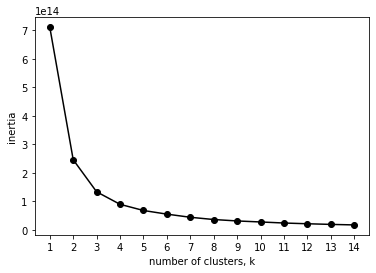

In [10]:
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,random_state=7,algorithm='full')
    
    # Fit model to samples
    model.fit(housesExperimental_K_nS)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [11]:
kmeans = KMeans(n_clusters=3,random_state=7)
kmeans.fit(housesExperimental_K_nS)
labels_predicted = kmeans.predict(housesExperimental_K_nS)

housesExperimental_K_nS["Cluster"] = labels_predicted

In [12]:
silhouete_ = metrics.silhouette_score(housesExperimental_K_nS, labels_predicted)
ari_ = metrics.adjusted_rand_score(kmeans.labels_, labels_predicted)

print("Silhouette score: {}\nARI score: {}".format(silhouete_,ari_))

Silhouette score: 0.5426747656722896
ARI score: 1.0


#### With Standardisation

In [13]:
housesExperimental_K_S = houses.copy(deep = True)

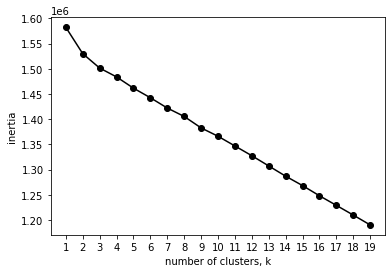

In [14]:
housesExperimental_K_S = StandardScaler().fit_transform(housesExperimental_K_S)
housesExperimental_K_S = pd.DataFrame(housesExperimental_K_S, columns=houses.columns)
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=7, algorithm='full')
    
    # Fit model to samples
    model.fit(housesExperimental_K_S)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [15]:
kmeans = KMeans(n_clusters=10, random_state=7)
kmeans.fit(housesExperimental_K_S)
labels_predicted = kmeans.predict(housesExperimental_K_S)

housesExperimental_K_S["Cluster"] = labels_predicted

In [16]:
silhouete_ = metrics.silhouette_score(housesExperimental_K_S, labels_predicted)
ari_ = metrics.adjusted_rand_score(kmeans.labels_, labels_predicted)

print("Silhouette score: {}\nARI score: {}".format(silhouete_,ari_))

Silhouette score: 0.09031787451945439
ARI score: 1.0


#### With Normalization

In [17]:
housesExperimental_K_N = houses.copy(deep = True)

In [18]:
housesExperimental_K_N = normalize(housesExperimental_K_N)
housesExperimental_K_N = pd.DataFrame(housesExperimental_K_N, columns=houses.columns)

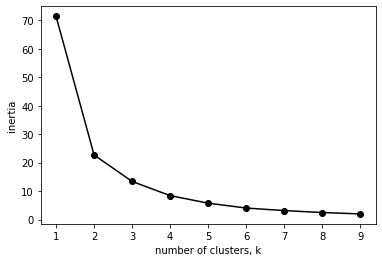

In [19]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=7, algorithm='full')
    
    # Fit model to samples
    model.fit(housesExperimental_K_N)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [20]:
kmeans = KMeans(n_clusters=4, random_state=7)
kmeans.fit(housesExperimental_K_N)
labels_predicted = kmeans.predict(housesExperimental_K_N)

housesExperimental_K_N["Cluster"] = labels_predicted

In [21]:
silhouete_ = metrics.silhouette_score(housesExperimental_K_N, labels_predicted)
ari_ = metrics.adjusted_rand_score(kmeans.labels_, labels_predicted)

print("Silhouette score: {}\nARI score: {}".format(silhouete_,ari_))

Silhouette score: 0.9831547912669274
ARI score: 1.0


#### With MinMax scaler

In [22]:
housesExperimental_K_MM = houses.copy(deep = True)

In [23]:
housesExperimental_K_MM = MinMaxScaler().fit_transform(housesExperimental_K_MM)
housesExperimental_K_MM = pd.DataFrame(housesExperimental_K_MM, columns=houses.columns)

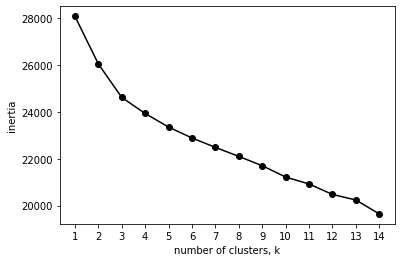

In [24]:
ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,random_state=7,algorithm='full')
    
    # Fit model to samples
    model.fit(housesExperimental_K_MM)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [25]:
kmeans = KMeans(n_clusters=9, random_state=7)
kmeans.fit(housesExperimental_K_MM)
labels_predicted = kmeans.predict(housesExperimental_K_MM)

housesExperimental_K_MM["Cluster"] = labels_predicted

In [26]:
silhouete_ = metrics.silhouette_score(housesExperimental_K_MM, labels_predicted)
ari_ = metrics.adjusted_rand_score(kmeans.labels_, labels_predicted)

print("Silhouette score: {}\nARI score: {}".format(silhouete_,ari_))

Silhouette score: 0.26335586420452456
ARI score: 1.0


<h1><center>Visualizing data for KMeans</center></h1>

<h2><center>PCA method</center></h2>

<h3><center>Helper functions for visualisation</center></h3>

In [27]:
def visualisation_PCA_components(X):
    """
    Displays bar plot with n_componenets and their explained % variance
    """
    # Create a PCA instance
    pca = PCA(n_components=X.shape[1])
    pca.fit_transform(X)
    
    fig = go.Figure(data=[go.Bar(x=pd.Series(range(pca.n_components_)),
                                 y=pca.explained_variance_ratio_,)])
    fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5, opacity=0.6)
    fig.update_layout(title_text='Explained variances of PCA components',
                      xaxis_title="PCA features",
                      yaxis_title="Variance explained %",)
    fig.show()
    

In [28]:
def visualisation_PCA_1D(X, n_clusters = 2, samples = 5000):
   
    plotX = pd.DataFrame(np.array(X.sample(samples)))
    plotX.columns = X.columns
    
    pca_1d = PCA(n_components=1)

    PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))
    PCs_1d.columns = ["PC1_1d"]

    plotX = pd.concat([plotX,PCs_1d], axis=1, join='inner')
    plotX["dummy"] = 0
    
    clusters = []
    for c in range(n_clusters):
        clusters.append(plotX[plotX["Cluster"] == c])

    #Instructions for building the 1-D plot
    data = []
    for c in range(n_clusters):
        trace = go.Scatter(
                        x = clusters[c]["PC1_1d"],
                        y = clusters[c]["dummy"],
                        mode = "markers",
                        name = "Cluster {}".format(c),
                        text = None)
        data.append(trace)

    title = "Visualizing Clusters in One Dimension Using PCA"
    layout = dict(title = title,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= '',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)

    iplot(fig)

In [29]:
def visualisation_PCA_2D(X, n_clusters = 2, samples = 5000):
    
    plotX = pd.DataFrame(np.array(X.sample(samples)))
    plotX.columns = X.columns

    pca_2d = PCA(n_components=2)
    
    PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))
    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')
    
    clusters = []
    for c in range(n_clusters):
        clusters.append(plotX[plotX["Cluster"] == c])

    #Instructions for building the 2-D plot
    data = []
    for c in range(n_clusters):
        trace = go.Scatter(
                        x = clusters[c]["PC1_2d"],
                        y = clusters[c]["PC2_2d"],
                        mode = "markers",
                        name = "Cluster {}".format(c),
                        text = None)
        data.append(trace)
    title = "Visualizing Clusters in Two Dimensions Using PCA"

    layout = dict(title = title,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)
    iplot(fig)

In [30]:
def visualisation_PCA_3D(X, n_clusters = 2, samples = 5000):
    
    plotX = pd.DataFrame(np.array(X.sample(samples)))
    plotX.columns = X.columns
        
    pca_3d = PCA(n_components=3)
    
    PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))
    PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    
    plotX = pd.concat([plotX,PCs_3d], axis=1, join='inner')
    
    clusters = []
    for c in range(n_clusters):
        clusters.append(plotX[plotX["Cluster"] == c])

    #Instructions for building the 3-D plot
    data = []
    for c in range(n_clusters):
        trace = go.Scatter3d(
                        x = clusters[c]["PC1_3d"],
                        y = clusters[c]["PC2_3d"],
                        z = clusters[c]["PC3_3d"],
                        mode = "markers",
                        name = "Cluster {}".format(c),
                        text = None)
        data.append(trace)

    title = "Visualizing Clusters in Three Dimensions Using PCA"

    layout = dict(title = title,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)

    iplot(fig)

<h3><center>Visualising KMeans</center></h3>

### housesExperimental_K_nS - KMeans without Standardisation

In [31]:
visualisation_PCA_components(housesExperimental_K_nS)

One atribute explaines whole data, we are taking 2 PCA components with previously defined elbow method for number of clusters (3)

In [32]:
visualisation_PCA_2D(housesExperimental_K_nS,3)

***

### housesExperimental_K_S - KMeans with Standardisation

In [33]:
visualisation_PCA_components(housesExperimental_K_S)

Atribute explanation is disperse, but we will take 3 for visualisation, from elbow method we decieded to use 6 clusters

In [34]:
visualisation_PCA_3D(housesExperimental_K_S,n_clusters=6)

***

### housesExperimental_K_N - KMeans with Normalization


In [35]:
visualisation_PCA_components(housesExperimental_K_N)

One atribute explaines whole data, we are will take a look with 1 and 2 PCA components, with number of clusters of 4 with previously defined elbow method.

In [36]:
visualisation_PCA_2D(housesExperimental_K_N,n_clusters=4)

In [37]:
visualisation_PCA_1D(housesExperimental_K_N,n_clusters=4)

***

### housesExperimental_K_MM - KMeans with MinMax scaler


In [38]:
visualisation_PCA_components(housesExperimental_K_MM)

Like before, 1 componenet explains nearly whole data, we are will take a look with 1 and 2 PCA components, with number of clusters of 9 with previously defined elbow method.

In [39]:
visualisation_PCA_1D(housesExperimental_K_MM,n_clusters=9)

In [40]:
visualisation_PCA_2D(housesExperimental_K_MM,n_clusters=9)

***

<h2><center>Distributed Stochastic Neighbor Embedding (T-SNE) method</center></h2>


<h3><center>Distributed Stochastic Neighbor Embedding (T-SNE) helper functions</center></h3>


In [41]:
def visualisation_TSNE_1D(X, n_clusters = 2, samples = 5000, perplexity = 50):
   
    plotX = pd.DataFrame(np.array(X.sample(samples)))
    plotX.columns = X.columns


    #T-SNE with one dimension
    tsne_1d = TSNE(n_components=1, perplexity=perplexity)

    TCs_1d = pd.DataFrame(tsne_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))
    TCs_1d.columns = ["TC1_1d"]
    
    plotX = pd.concat([plotX,TCs_1d], axis=1, join='inner')
    plotX["dummy"] = 0
    
    clusters = []
    for c in range(n_clusters):
        clusters.append(plotX[plotX["Cluster"] == c])

    #Instructions for building the 1-D plot
    data = []
    for c in range(n_clusters):
        trace = go.Scatter(
                        x = clusters[c]["TC1_1d"],
                        y = clusters[c]["dummy"],
                        mode = "markers",
                        name = "Cluster {}".format(c),
                        text = None)
        data.append(trace)

    title = "Visualizing Clusters in One Dimension Using T-SNE (perplexity=" + str(perplexity) + ")"
    layout = dict(title = title,
                  xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= '',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)

    iplot(fig)

In [42]:
def visualisation_TSNE_2D(X, n_clusters = 2, samples = 5000, perplexity = 50):
    
    plotX = pd.DataFrame(np.array(X.sample(samples)))
    plotX.columns = X.columns
        
    tsne_2d = TSNE(n_components=2, perplexity=perplexity)
    
    TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))
    TCs_2d.columns = ["TC1_2d","TC2_2d"]

    plotX = pd.concat([plotX,TCs_2d], axis=1, join='inner')
    
    clusters = []
    for c in range(n_clusters):
        clusters.append(plotX[plotX["Cluster"] == c])

    #Instructions for building the 2-D plot
    data = []
    for c in range(n_clusters):
        trace = go.Scatter(
                        x = clusters[c]["TC1_2d"],
                        y = clusters[c]["TC2_2d"],
                        mode = "markers",
                        name = "Cluster {}".format(c),
                        text = None)
        data.append(trace)
    title = "Visualizing Clusters in Two Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

    layout = dict(title = title,
                  xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)
    iplot(fig)

In [43]:
def visualisation_TSNE_3D(X, n_clusters = 2, samples = 5000, perplexity = 50):
 
    plotX = pd.DataFrame(np.array(X.sample(samples)))
    plotX.columns = X.columns
    
    tsne_3d = TSNE(n_components=3, perplexity=perplexity)
    
    TCs_3d = pd.DataFrame(tsne_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))
    TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]
    
    plotX = pd.concat([plotX,TCs_3d], axis=1, join='inner')
    
    clusters = []
    for c in range(n_clusters):
        clusters.append(plotX[plotX["Cluster"] == c])

    #Instructions for building the 3-D plot
    data = []
    for c in range(n_clusters):
        trace = go.Scatter3d(
                        x = clusters[c]["TC1_3d"],
                        y = clusters[c]["TC2_3d"],
                        z = clusters[c]["TC3_3d"],
                        mode = "markers",
                        name = "Cluster {}".format(c),
                        text = None)
        data.append(trace)

    title = "Visualizing Clusters in Three Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

    layout = dict(title = title,
                  xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
                  yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
                 )

    fig = dict(data = data, layout = layout)

    iplot(fig)

***

### housesExperimental_K_S - KMeans with Standardisation

In [44]:
visualisation_TSNE_1D(housesExperimental_K_S, n_clusters=6)

In [45]:
visualisation_TSNE_2D(housesExperimental_K_S, n_clusters=6)

In [46]:
visualisation_TSNE_3D(housesExperimental_K_S, n_clusters=6)

***

<h2><center>Hierarchical clustering</center></h2>


In [47]:
housesExperimental_H_N = houses.copy(deep = True)

In [48]:
housesExperimental_H_N = normalize(housesExperimental_H_N)
housesExperimental_H_N = pd.DataFrame(housesExperimental_H_N, columns=houses.columns)

In [49]:
den_linkage = shc.linkage(housesExperimental_H_N, method='ward')

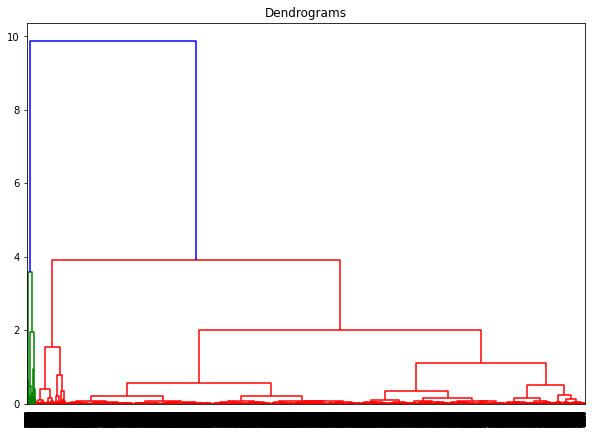

In [50]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(den_linkage)
plt.axhline(y=3, color='r', linestyle='--')
plt.show()

In [53]:
hierarchical = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
labels_predicted = hierarchical.fit_predict(housesExperimental_H_N)

housesExperimental_H_N['Cluster'] = labels_predicted

In [54]:
silhouete_ = metrics.silhouette_score(housesExperimental_H_N, labels_predicted)
print("Silhouette score: {}".format(silhouete_))

Silhouette score: 0.9827373968023508



<h3><center>Grade</center></h3>

![image info](./plots/shc/grade.png)

***

<h3><center>Home age</center></h3>

![image info](./plots/shc/home_age.png)

***

<h3><center>Living area</center></h3>

![image info](./plots/shc/sqft_living.png)

***

<h3><center>Waterfront</center></h3>

![image info](./plots/shc/waterfront.png)


In [59]:
# plt.figure(figsize=(10, 7))  
# for col in housesExperimental_H_N.columns:
#     plt.title("Price and {}".format(col))
#     plt.xlabel('price')
#     plt.ylabel(col)
#     plt.scatter(housesExperimental_H_N['price'], housesExperimental_H_N[col],
#                 c=hierarchical.labels_)
#     plt.savefig('plots/shc/{}.png'.format(col), bbox_inches='tight')
#     plt.clf()